In [42]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
#1 Prepare the data
RatesData = pd.read_csv("StatisticalModelData2020.csv")
RatesData = RatesData.set_index('DATE')
RatesData.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
DATE,,,,,,,
1/5/1981,13.52,13.09,12.289,12.28,12.294,12.152,11.672
1/6/1981,13.58,13.16,12.429,12.31,12.214,12.112,11.672
1/7/1981,14.50,13.90,12.929,12.78,12.614,12.382,11.892
1/8/1981,14.76,14.00,13.099,12.95,12.684,12.352,11.912
1/9/1981,15.20,14.30,13.539,13.28,12.884,12.572,12.132


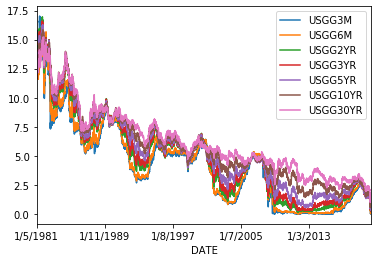

In [44]:
RatesData.plot()

In [45]:
#2 Estimate the 3-factor model using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3,svd_solver = 'full')
pca.fit(RatesData)
print('Explained variance by factors:\n', pca.explained_variance_.round(1))

Explained variance by factors:
 [80.8  1.5  0.1]


In [46]:
#2.1 Define factors and factor loadings, including zero loading
pca_factors = pd.DataFrame(pca.transform(RatesData), 
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)], 
                           index=RatesData.index)
pca_factors.head()

,pca.f1,pca.f2,pca.f3
DATE,,,
1/5/1981,19.564286,2.284584,1.399668
1/6/1981,19.638367,2.398658,1.387897
1/7/1981,20.988664,2.921312,1.591843
1/8/1981,21.286713,3.104681,1.581520
1/9/1981,22.108056,3.253927,1.605642


In [47]:
zero_loadings = RatesData.mean()
zero_loadings

USGG3M      4.134590
USGG6M      4.305031
USGG2YR     4.830645
USGG3YR     5.035362
USGG5YR     5.384652
USGG10YR    5.850849
USGG30YR    6.256458
dtype: float64

In [48]:
#2.1 Define factors and factor loadings, including zero loading
maturities = pd.DataFrame({'maturities':[0.25,0.5,2,3,5,10,30]})
pca_loadings = pd.DataFrame(pca.components_)
pca_loadings = pca_loadings.transpose()
pca_loadings.columns = ['pca.l{}'.format(i+1) for i in range(pca.n_components_)]
pca_loadings = maturities.join(pca_loadings)
pca_loadings

,maturities,pca.l1,pca.l2,pca.l3
0,0.25,0.379917,0.496753,0.519905
1,0.50,0.388320,0.433437,0.155250
2,2.00,0.408086,0.139091,-0.411736
3,3.00,0.402157,0.001449,-0.451624
4,5.00,0.385797,-0.212796,-0.284104
5,10.00,0.355729,-0.434704,0.134231
6,30.00,0.318157,-0.558364,0.483086


In [49]:
#2.2 Calculate relative importance of factors
centered = RatesData.copy()
for column in centered.columns:
    centered[column] -= np.mean(centered[column])
centered.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
DATE,,,,,,,
1/5/1981,9.38541,8.784969,7.458355,7.244638,6.909348,6.301151,5.415542
1/6/1981,9.44541,8.854969,7.598355,7.274638,6.829348,6.261151,5.415542
1/7/1981,10.36541,9.594969,8.098355,7.744638,7.229348,6.531151,5.635542
1/8/1981,10.62541,9.694969,8.268355,7.914638,7.299348,6.501151,5.655542
1/9/1981,11.06541,9.994969,8.708355,8.244638,7.499348,6.721151,5.875542


In [50]:
cov = np.matrix(centered.cov())
cov

matrix([[12.07624187, 12.25213852, 12.6037023 , 12.31757105, 11.66737414,
         10.60288664,  9.37779561],
        [12.25213852, 12.47951042, 12.88855342, 12.60968787, 11.957975  ,
         10.87988863,  9.62780839],
        [12.6037023 , 12.88855342, 13.51135191, 13.28564009, 12.68879364,
         11.63026804, 10.35055849],
        [12.31757105, 12.60968787, 13.28564009, 13.09588544, 12.55291529,
         11.55058178, 10.30992036],
        [11.66737414, 11.957975  , 12.68879364, 12.55291529, 12.11083228,
         11.2258628 , 10.07780278],
        [10.60288664, 10.87988863, 11.63026804, 11.55058178, 11.2258628 ,
         10.51629676,  9.51911684],
        [ 9.37779561,  9.62780839, 10.35055849, 10.30992036, 10.07780278,
          9.51911684,  8.6844995 ]])

In [51]:
eigenvalues = np.linalg.eigvals(cov)
eigenvalues

array([8.08054224e+01, 1.51429471e+00, 1.29060067e-01, 1.50518222e-02,
       7.66446253e-03, 2.22749682e-03, 8.97204453e-04])

<BarContainer object of 3 artists>

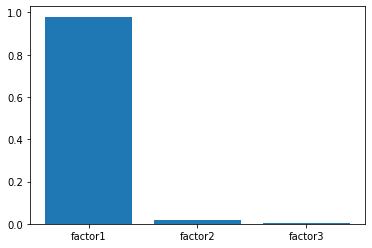

In [52]:
importance = eigenvalues/sum(eigenvalues)
x = ['factor1','factor2','factor3']
plt.bar(x,importance[0:3])

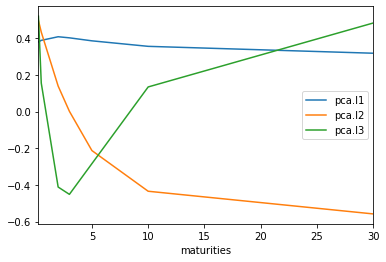

In [53]:
#2.3 Plot and interpret the shapes of factor loadings
pca_loadings.plot(x='maturities',y=['pca.l1','pca.l2','pca.l3'])
#interpretation：pca.l1 is very flat across maturities, which means factor1 has similar effects to yields of all maturites
# pca.l2 is downward sloping as maturity increases, which means factor2 impacts short term yields most
# pca.l3 begins to downward slope but goes upward when maturity is larget than 2.5. So when maturity is shorter than 2.5, 
# factor3 matteres more to short term yields, but when maturity is longer than 2.5, longer term yields is more correlated to factor3

In [54]:
#3 Calculate historical volatilities and correlation coefficients of factors
delta_f = pca_factors.diff()
delta_f_var = delta_f.rolling(len(delta_f),min_periods=2).var()
delta_f_cor = delta_f.rolling(len(delta_f),min_periods=2).corr()
delta_f_var_20 = delta_f.rolling(30).var()
delta_f_cor_20 = delta_f.rolling(30).corr()

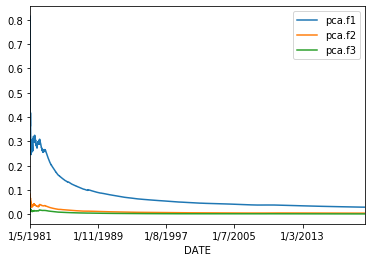

In [82]:
delta_f_var.plot()
#plt.legend(pca.f1','pca.f2','pca.f3)

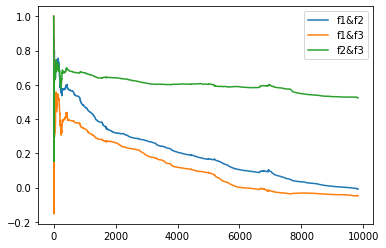

In [84]:
plt.plot(delta_f_cor['pca.f1'].xs(key = 'pca.f2', level = 1).values,label = "f1&f2")
plt.plot(delta_f_cor['pca.f1'].xs(key = 'pca.f3', level = 1).values,label = "f1&f3")
plt.plot(delta_f_cor['pca.f2'].xs(key = 'pca.f3', level = 1).values,label = "f2&f3")
plt.legend()

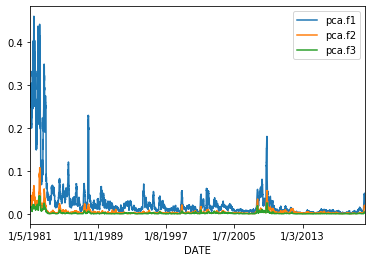

In [85]:
delta_f_var_20.plot()

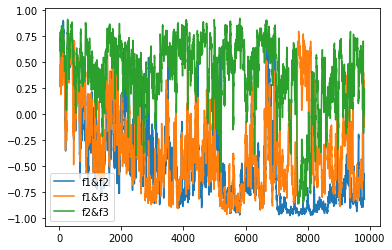

In [87]:
plt.plot(delta_f_cor_20['pca.f1'].xs(key = 'pca.f2', level = 1).values,label = "f1&f2")
plt.plot(delta_f_cor_20['pca.f1'].xs(key = 'pca.f3', level = 1).values,label = "f1&f3")
plt.plot(delta_f_cor_20['pca.f2'].xs(key = 'pca.f3', level = 1).values,label = "f2&f3")
plt.legend()

In [59]:
#4 Find historical estimates of volatilities of factors of last month 
pca_factors['4/1/2020':][['pca.f1','pca.f2','pca.f3']].std()

pca.f1    0.112582
pca.f2    0.041999
pca.f3    0.060158
dtype: float64

In [60]:
#5 Calculate time series of each of 7 rates predicted by the model
#prediction = pd.DataFrame(index = RatesData.index, columns = RatesData.columns)
prediction = pd.DataFrame(np.matrix(pca_factors[['pca.f1','pca.f2','pca.f3']]) \
                          @ np.matrix((pca_loadings[['pca.l1','pca.l2','pca.l3']].transpose())))
prediction.index = RatesData.index
prediction.columns = RatesData.columns
for column in prediction.columns:
    prediction[column] += RatesData[column].mean()
prediction.head()

,USGG3M,USGG6M,USGG2YR,USGG3YR,USGG5YR,USGG10YR,USGG30YR
DATE,,,,,,,
1/5/1981,13.429954,13.109752,12.556030,12.274461,12.048702,12.005192,11.881506
1/6/1981,13.508645,13.186136,12.606975,12.309734,12.056352,11.980376,11.835695
1/7/1981,14.387307,13.968683,13.146737,12.761416,12.408132,12.260892,12.071993
1/8/1981,14.586263,14.162297,13.298122,12.886206,12.487031,12.285819,12.059446
1/9/1981,14.984985,14.549675,13.644128,13.205837,12.765291,12.516355,12.249081


In [61]:
#6 Fit parametric forms from slide 33 to zero loading and each of the first 3 vectors of factor loadings
from scipy.optimize import curve_fit
def func1(tau, al1, al2, bl1, bl2):
    return (bl1*(1-np.exp(-al1*tau))/(al1*tau)+bl2*(1-np.exp(-al2*tau))/(al2*tau))
def func2(tau, al1, al2, al3, bl1, bl2, bl3):
    return (bl1*(1-np.exp(-al1*tau))/(al1*tau)+bl2*(1-np.exp(-al2*tau))/(al2*tau)+bl3*(1-np.exp(-al3*tau))/(al3*tau))
def func3(tau, al1, al2, al3, al4, bl1, bl2, bl3, bl4):
    return (bl1*(1-np.exp(-al1*tau))/(al1*tau)+bl2*(1-np.exp(-al2*tau))/(al2*tau)+bl3*(1-np.exp(-al3*tau))/(al3*tau)+bl4*(1-np.exp(-al4*tau))/(al4*tau))

In [62]:
# zero loading
popt, pcov = curve_fit(func1, pca_loadings['maturities'], zero_loadings, p0 = (0.650,0.004,-1.130,0.539), bounds = ([0,0,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf]))
popt

array([ 3.93615550e-01,  2.80732750e-08, -2.39487219e+00,  6.45166080e+00])

In [63]:
# loading1
popt, pcov = curve_fit(func2, pca_loadings['maturities'], pca_loadings['pca.l1'], p0 = (0.320,0.006,36.550,0.070,0.285,-0.292), bounds = ([0,0,0,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
popt

array([ 1.41360804e-01,  9.55110991e-08,  2.24974949e+01,  1.45011825e-01,
        2.83814211e-01, -2.85699544e-01])

In [64]:
# loading2
popt, pcov = curve_fit(func1, pca_loadings['maturities'], pca_loadings['pca.l2'], p0 = (0.650,0.004,-1.130,0.539), bounds = ([0,0,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf]))
popt

array([ 0.01607828,  0.39656882, -0.8534644 ,  1.41652317])

In [65]:
# loading3
popt, pcov = curve_fit(func3, pca_loadings['maturities'], pca_loadings['pca.l3'], p0 = (4.200e-01,5.000e-08,5.000e-01,2.876e+00,-1.920,0.620,-0.410,3.035), bounds = ([0,0,0,0,-np.inf,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]),maxfev = 2000)
popt

C:\Users\Krist\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([ 5.61545851e-01,  1.83864395e-02,  5.72448840e-01,  6.52798973e+01,
       -1.91228192e+02,  9.54722740e-01,  1.90574794e+02,  6.74179510e+00])

In [66]:
#7 
def func4(tau, al1, al2, bl1, bl2):
    return (bl1*np.exp(-al1*tau)+bl2*np.exp(-al2*tau))
def func5(tau, al1, al2, al3, bl1, bl2, bl3):
    return (bl1*np.exp(-al1*tau)+bl2*np.exp(-al2*tau)+bl3*np.exp(-al3*tau))
def func6(tau, al1, al2, al3, al4, bl1, bl2, bl3, bl4):
    return (bl1*np.exp(-al1*tau)+bl2*np.exp(-al2*tau)+bl3*np.exp(-al3*tau)+bl4*np.exp(-al4*tau))

In [67]:
fr = func4(5,3.93615550e-01,  2.80732750e-08, -2.39487219e+00,  6.45166080e+00)+\
func5(5,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)*pca_factors['pca.f1']+\
func4(5,0.01607828,0.39656882,-0.8534644,1.41652317)*pca_factors['pca.f2']+\
func6(5,5.61545851e-01,1.83864395e-02,5.72448840e-01,6.52798973e+01,-1.91228192e+02,9.54722740e-01,1.90574794e+02,6.74179510e+00)*pca_factors['pca.f3']

In [68]:
print(fr[:10])

DATE
1/5/1981     12.025062
1/6/1981     11.981190
1/7/1981     12.196456
1/8/1981     12.191430
1/9/1981     12.400191
1/12/1981    12.289947
1/13/1981    12.324682
1/14/1981    12.329858
1/15/1981    12.477511
1/16/1981    12.363564
dtype: float64


In [69]:
price = np.exp(-(func1(4.5,3.93615550e-01,  2.80732750e-08, -2.39487219e+00,  6.45166080e+00)*4.5+\
func2(4.5,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)*4.5*pca_factors['pca.f1']+\
func1(4.5,0.01607828,0.39656882,-0.8534644,1.41652317)*4.5*pca_factors['pca.f2']+\
func3(4.5,5.61545851e-01,1.83864395e-02,5.72448840e-01,6.52798973e+01,-1.91228192e+02,9.54722740e-01,1.90574794e+02,6.74179510e+00)*4.5*pca_factors['pca.f3']))

In [70]:
print(price[:10])

DATE
1/5/1981     2.441508e-24
1/6/1981     2.290758e-24
1/7/1981     4.325669e-25
1/8/1981     2.893492e-25
1/9/1981     7.971598e-26
1/12/1981    2.780937e-25
1/13/1981    2.283016e-25
1/14/1981    4.956336e-25
1/15/1981    1.831097e-25
1/16/1981    3.485195e-25
dtype: float64


C:\Users\Krist\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Krist\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.000e+00, 1.000e+00, 3.000e+00, 2.000e+01, 1.860e+02, 2.990e+03,
        5.947e+03, 6.170e+02, 5.500e+01, 7.000e+00]),
 array([-0.79313604, -0.66565069, -0.53816534, -0.41067999, -0.28319463,
        -0.15570928, -0.02822393,  0.09926142,  0.22674677,  0.35423212,
         0.48171747]),
 <a list of 10 Patch objects>)

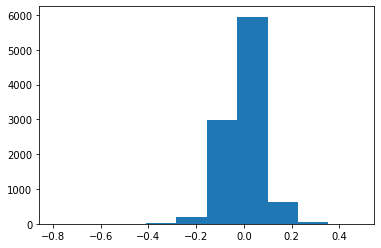

In [71]:
increment = fr.diff()
plt.hist(increment, rwidth = 1)

(array([   0.,    0.,    0.,    0., 4845., 4982.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

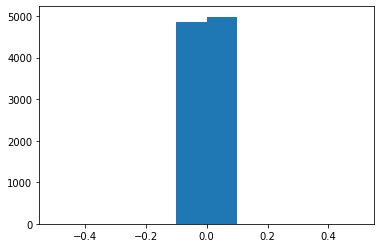

In [72]:
increment = price.diff()
plt.hist(increment,bins = [-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5])

In [73]:
#8
sigma1 = pca_factors['pca.f1'].diff().var()
sigma2 = pca_factors['pca.f2'].diff().var()
sigma3 = pca_factors['pca.f3'].diff().var()

In [74]:
def func_cor(tau):
    b10 = func5(0,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    b20 = func4(0,0.01607828,0.39656882,-0.8534644,1.41652317)
    b30 = func6(0,5.61545851e-01,1.83864395e-02,5.72448840e-01,6.52798973e+01,-1.91228192e+02,9.54722740e-01,1.90574794e+02,6.74179510e+00)
    b1t = func5(tau,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    b2t = func4(tau,0.01607828,0.39656882,-0.8534644,1.41652317)
    b3t = func6(tau,5.61545851e-01,1.83864395e-02,5.72448840e-01,6.52798973e+01,-1.91228192e+02,9.54722740e-01,1.90574794e+02,6.74179510e+00)
    cor = (b10*b1t*sigma1+b20*b2t*sigma2+b30*b3t*sigma3)/((b10**2*sigma1+b20**2*sigma2+b30**2*sigma3)*(b1t**2*sigma1+b2t**2*sigma2+b3t**2*sigma3))**0.5
    return cor
def func_cor1(tau):
    b10 = func5(0,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    b1t = func5(tau,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    cor = (b10*b1t*sigma1)/((b10**2*sigma1)*(b1t**2*sigma1))**0.5
    return cor
def func_cor2(tau):
    b10 = func5(0,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    b20 = func4(0,0.01607828,0.39656882,-0.8534644,1.41652317)
    b1t = func5(tau,1.41360804e-01,9.55110991e-08,2.24974949e+01,1.45011825e-01,2.83814211e-01,-2.85699544e-01)
    b2t = func4(tau,0.01607828,0.39656882,-0.8534644,1.41652317)
    cor = (b10*b1t*sigma1+b20*b2t*sigma2)/((b10**2*sigma1+b20**2*sigma2)*(b1t**2*sigma1+b2t**2*sigma2))**0.5
    return cor

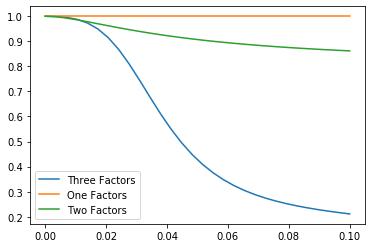

In [89]:
x = np.linspace(0,0.1,30)
plt.plot(x,func_cor(x), label = 'Three Factors')
plt.plot(x,func_cor1(x), label = 'One Factors')
plt.plot(x,func_cor2(x), label = 'Two Factors')
plt.legend()

In [76]:
#9 
b09 = func1(0.75,0.3667761,0.0010000,-2.5020220,6.5669031)*9
b03 = func1(0.25,0.3667761,0.0010000,-2.5020220,6.5669031)*3
b19 = func2(0.75,0.1472244,0.0010000,36.5486585,0.1379750,0.2908608,-0.4631877)*9
b13 = func2(0.25,0.1472244,0.0010000,36.5486585,0.1379750,0.2908608,-0.4631877)*3
b29 = func1(0.75,0.01618005,0.39616503,-0.85466071,1.41763272)*9
b23 = func1(0.25,0.01618005,0.39616503,-0.85466071,1.41763272)*3
b39 = func3(0.75,0.20184969,0.04078695,0.20274699,2.08203408,-2.47831969,1.68864335,-0.75981332,2.54790398)*9
b33 = func3(0.25,0.20184969,0.04078695,0.20274699,2.08203408,-2.47831969,1.68864335,-0.75981332,2.54790398)*3
forward = (b09-b03)/6+((b19-b13)*pca_factors['pca.f1']+(b29-b23)*pca_factors['pca.f2']+(b39-b33)*pca_factors['pca.f3'])/6

In [77]:
'4/17/2014' in forward.index

True

In [78]:
forward.loc['4/17/2014']

-0.05677739601579379